In [1]:
# [1]
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pysimul
from common import *
from math import *

In [2]:
# [2]
reset_type = 'poisson'
path = "data-2d-poisson-x0var/"
i_beg = 0
param_i = 0

In [33]:
# [3]
simul = pysimul.PySimul()
simul['D'] = D = 1
simul['reset_rate'] = α = 25
#simul['reset_period'] = rT = 0.002
simul['x0sigma'] = σ = [0, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5][param_i]
simul['2D-Rtol'] = Rtol = 0.05
simul.start()

if reset_type == 'poisson':
    th_tau_2d = fpt_2d_poisson_tau
    th_c = lambda L: fpt_poisson_c(α, D, L)
elif reset_type == 'per':
    th_tau_2d = None
    th_c = lambda L: fpt_periodic_c(rT, D, L)
param_i += 1
ended = False

In [4]:
# [4]
def timer_f ():
    global simul, ended
    if simul is None:
        return 1
    if simul['n_trajectories'] >= 10000 and not ended:
        ended = True
        return 2
    return 0

In [5]:
%%javascript
var sfml_event_poll_timer = setInterval(function() {
    Jupyter.notebook.kernel.execute("print(timer_f())", { iopub : { output : function (data) {
        console.log(data.content.text)
        if (data.content.text == "1\n" || data.content.text === undefined) {
            clearInterval(sfml_event_poll_timer);
        } else if (data.content.text == "2\n") {
            Jupyter.notebook.execute_cells([7,8,9,3]);
        }
    }}})
}, 2000);

<IPython.core.display.Javascript object>

In [29]:
# [6]
param_i-1, simul['n_trajectories']

(5, 7674)

In [30]:
# [7]
simul.explicit_lock()
Rtarg = simul['first_times_xtarg'][0]
Δt = simul['Delta_t']

first_times = simul['first_times-0']
n_traj = len(first_times)
mfpt = np.mean(first_times)

path2 = path+str(i_beg+param_i)
np.savetxt(path2+"-ft.csv", first_times, fmt='%.2e')
d = {
    'D': D,
    'part_m': 0,
    'x0sigma': σ,
    'L': Rtarg,
    'b': Rtarg/σ,
    'c': th_c(Rtarg),
    'mfpt': mfpt,
    'fpt_stdev': np.std(first_times),
    'n_traj': len(first_times),
    'Delta_t': Δt,
    'Rtol': Rtol,
    'a': Rtol / Rtarg
}
if reset_type == 'poisson':
    d['reset_rate'] = α
elif reset_type == 'per':
    d['reset_period'] = rT

df = pd.DataFrame(list(d.items())).set_index(0)
df.to_csv(path2+"-params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')
simul.explicit_unlock()
df.T

,D,part_m,x0sigma,L,b,c,mfpt,fpt_stdev,n_traj,Delta_t,Rtol,a,reset_rate
1,1.0,0.0,0.2,0.2,1.0,1.0,0.156585,0.176238,10017.0,0.000001,0.05,0.25,25.0


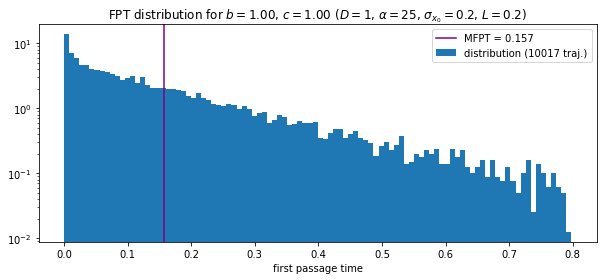

In [31]:
# [8]
b = Rtarg/σ
c = th_c(Rtarg)
a = Rtol/Rtarg
mfpt_th = Rtarg**2/(4*D)*th_tau_2d(b,c,a)

plt.figure(figsize=(10,4))
fpt_max = 5*mfpt_th
plt.hist(first_times, bins=100, range=(0,fpt_max), weights=100/fpt_max*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
plt.axvline(x=mfpt, color='purple', label="MFPT = {:.3f}".format(mfpt))
plt.yscale('log')
plt.xlabel("first passage time")
if reset_type == 'poisson':
    plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={}$, $\alpha={}$, $\sigma_{{x_0}}={}$, $L={}$)".format(b, c, D, α, σ, Rtarg))
elif reset_type == 'per':
    plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={}$, $T_\operatorname{{res}}={}$, $\sigma_{{x_0}}={}$, $L={}$)".format(b, c, D, rT, σ, Rtarg))
plt.legend()

In [32]:
# [9]
simul.end()

In [7]:
simul['pause'] = 1